# Определение стоимости автомобилей

Описание исследования.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)


Цель исследования.

Построить модель для приложения , которая умеет определять рыночную стоимость автомабиля. 

Цель исследования.

Суть исследования. Провести анализ данных рынка продаж автомобилей, исходя от которого будет построена модель МО, которое будет встроена в приложения. В итоге приложение должно привлечь больше клиентов.

Задачи исследования.

Загружаем данные.Обрабатываем эти данные(пропуски,дубликаты,аномалии). Создаём МО модель для предсказания.Проверяем на темтовых данных.Анализируем работу моделей.

Часть 1. Изучение общей информации:

1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.
2. Нахождение и ликвидация пропусков.

Часть 2. Подготовка данных:

1. Приведение данных к нужным типам.
2. Нахождение и исправление аномалий и ошибок.
 
Часть 3. Подготовка выборки 

1. Подготовка выборки для обучения моделей

Часть 4. Обучение моделей

1. Обучение разных модели(LinearRegression,DecisionTreeRegressor,LGBMRegressor,RandomForestRegressor)

Часть 5. Проанализировать время работы МО.

1. Проанализировать время обучения, время предсказания и качество моделей.

Часть 6. Выберать лучшую модель

1. Выберать лучшую модель, проверить её качество на тестовой выборке.

## Подготовка данных

In [1]:
!pip install phik -q
!pip install category_encoders -q
!pip install -U scikit-learn -q
!pip install --upgrade jupyter -q
!pip install --upgrade ipykernel -q

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#Испортипуем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import statsmodels.api as sm
from scipy import stats
from scipy.stats import spearmanr
import sklearn, phik
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,OrdinalEncoder,RobustScaler,TargetEncoder
from category_encoders import MEstimateEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from phik.report import plot_correlation_matrix
plt.rcParams["figure.figsize"] = (8,8)
pd.set_option('display.max_rows', None)
RANDOM_STATE = 42
TEST_SIZE = 0.4
#import warnings
#warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
pth1 = '/datasets/autos.csv'
pth2 = 'C:/Users/Admin/Downloads/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1,parse_dates=['DateCrawled','DateCreated','LastSeen'])
elif os.path.exists(pth2):
    data_one = pd.read_csv(pth2,parse_dates=['DateCrawled','DateCreated','LastSeen'])
else:
    print('Something is wrong')

In [5]:
#Изучаем загруженные файлы
display(data.head(10))
print()
display(data.info(0))
print()
display(data.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64  

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
#меняем названия столбцов
data = data.rename(columns={'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox',
                            'Power' : 'power','Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth' : 'registration_month',
                           'FuelType' : 'fuel_type','Brand': 'brand', 'Repaired': 'repaired'})

In [7]:
#Проверяем пропуски и дубликаты
display(data.isna().sum().to_frame())
print()
display(data.duplicated().sum())
print()
display(data.index.duplicated().sum())
print()

,0
DateCrawled,0
price,0
vehicle_type,37490
registration_year,0
gearbox,19833
power,0
model,19705
kilometer,0
registration_month,0
fuel_type,32895


4

0

In [8]:
#Удаляем явные дубликаты
data = data.drop_duplicates()

In [9]:
#Проверям пропуски по процентам 
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

DateCrawled - 0%
price - 0%
vehicle_type - 11%
registration_year - 0%
gearbox - 6%
power - 0%
model - 6%
kilometer - 0%
registration_month - 0%
fuel_type - 9%
brand - 0%
repaired - 20%
DateCreated - 0%
NumberOfPictures - 0%
PostalCode - 0%
LastSeen - 0%


In [10]:
#Проверяем  уникальные значения(неявные дубликаты)
data.vehicle_type.value_counts (dropna=False).to_frame()

,vehicle_type
sedan,91457
small,79830
wagon,65165
NaN,37490
bus,28775
convertible,20203
coupe,16161
suv,11996
other,3288


In [11]:
#Добовляем пропуски к обозначению 'other'
data['vehicle_type'] = data['vehicle_type'].replace({np.nan : 'other'})
data.vehicle_type.value_counts (dropna=False).to_frame()

,vehicle_type
sedan,91457
small,79830
wagon,65165
other,40778
bus,28775
convertible,20203
coupe,16161
suv,11996


In [12]:
#Проверяем  уникальные значения(неявные дубликаты) 
data.gearbox .value_counts(dropna=False).to_frame()

,gearbox
manual,268249
auto,66283
NaN,19833


In [13]:
#Добовляем пропуски к обозначению 'other'
data['gearbox'] = data['gearbox'].replace({np.nan : 'other'})
data.gearbox.value_counts (dropna=False).to_frame()

,gearbox
manual,268249
auto,66283
other,19833


In [14]:
#Проверяем  уникальные значения(неявные дубликаты) 
data.model.value_counts(dropna=False).to_frame()

,model
golf,29232
other,24420
3er,19761
NaN,19705
polo,13066
corsa,12570
astra,10809
passat,10145
a4,9900
c_klasse,8312


In [15]:
#Добовляем пропуски к обозначению 'other'
data['model'] = data['model'].replace({np.nan : 'other'})
data.model.value_counts (dropna=False).to_frame()

,model
other,44125
golf,29232
3er,19761
polo,13066
corsa,12570
astra,10809
passat,10145
a4,9900
c_klasse,8312
5er,7868


In [16]:
#Проверяем  уникальные значения(неявные дубликаты) 
data.fuel_type .value_counts(dropna=False).to_frame()

,fuel_type
petrol,216349
gasoline,98719
NaN,32895
lpg,5310
cng,565
hybrid,233
other,204
electric,90


In [17]:
#Добовляем пропуски к обозначению 'other'
data['fuel_type'] = data['fuel_type'].replace({'lpg' : 'gas', 'cng' : 'gas','gasoline' : 'petrol',np.nan : 'other'})
data.fuel_type.value_counts (dropna=False).to_frame()

,fuel_type
petrol,315068
other,33099
gas,5875
hybrid,233
electric,90


In [18]:
#Проверяем  уникальные значения(неявные дубликаты) 
data.brand.value_counts(dropna=False,).to_frame()

,brand
volkswagen,77012
opel,39931
bmw,36914
mercedes_benz,32044
audi,29456
ford,25179
renault,17927
peugeot,10998
fiat,9643
seat,6907


In [19]:
#Проверяем  уникальные значения(неявные дубликаты) 
data.repaired.value_counts(dropna=False).to_frame()

,repaired
no,247158
NaN,71154
yes,36053


In [20]:
display(data.duplicated().sum())
print()
display(data.index.duplicated().sum())

0

0

### Вывод

Загрузила данные.Поменяла название столбцов.  Были 4 дубликата,удалила их. Есть пропуски DateCrawled - 0%,
VehicleType - 11%,Gearbox - 6%,Model - 6%,FuelType - 9%,Repaired - 20%. В признаке 'Repaired' и 'VehicleType' процент пропусков больше 10%. Обядинила пропуски со значением 'other'. Обработать пропуски буду в пайплайне.Удалила признаки 'DateCrawled,DateCreated,LastSeen,NumberOfPictures,PostalCode,LastSeen' по скольку они не несут полезной информации для МО. Есть аномалии в количественных признаках 'price,registration_year,power,registration_month'.

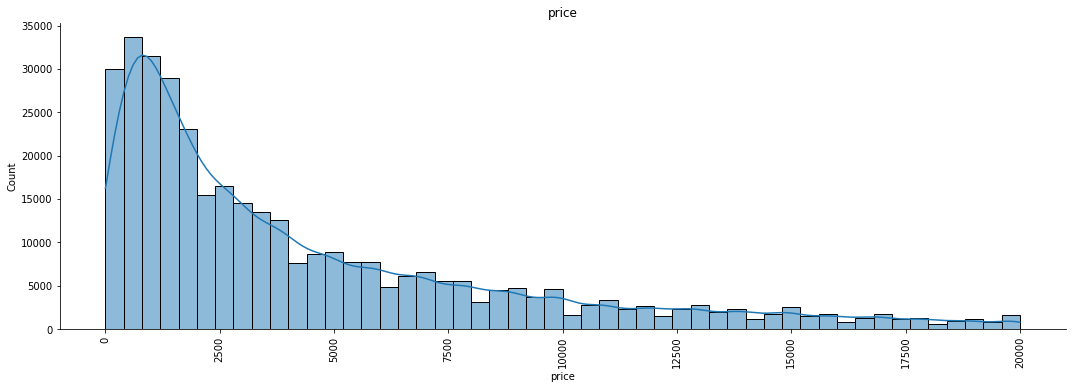

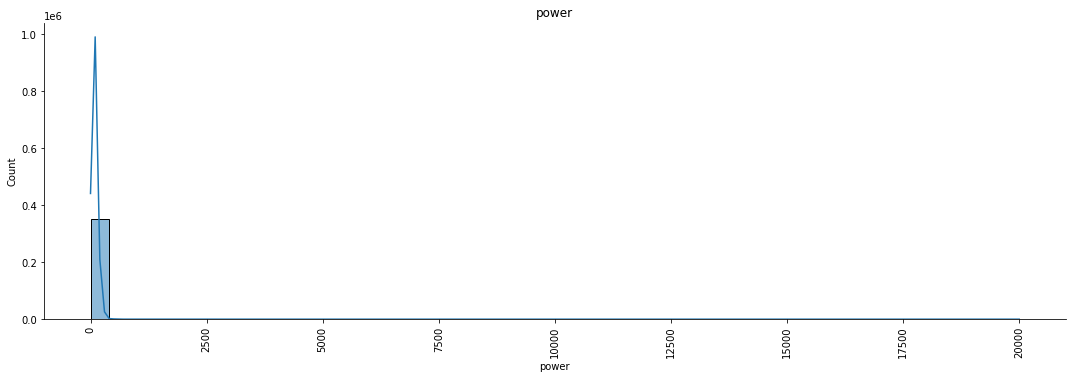

In [21]:
#Получаем график по категориальным признакам
for i,col in enumerate(['price','power']):
    sns.displot(data[col],kde=True, bins=50, aspect=3)
    plt.xticks(rotation=90)
    plt.title(col, fontsize=12)
    plt.show();

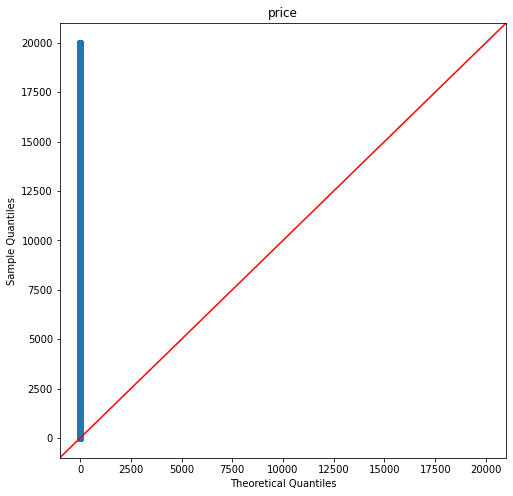

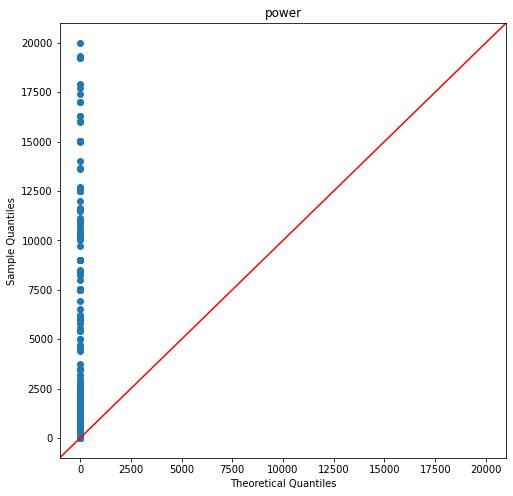

In [22]:
#Создаём qq график
for i,col in enumerate(['price','power']):
    sm. qqplot (data[col], line='45')
    plt.title(col, fontsize=12)
    plt.show();

По гистограмму график цены  и  мощности не имеет нормальное распределение, это видно и по qq графику.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


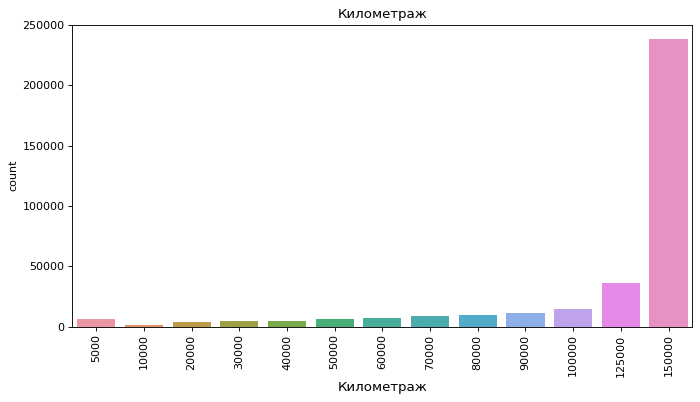

In [23]:
#Отдельно получаем график по километражу
from matplotlib.pyplot import figure
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='r')
sns.countplot(data['kilometer'])
plt.title('Километраж')
plt.xticks(rotation=90)
plt.xlabel('Километраж',fontsize=12)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


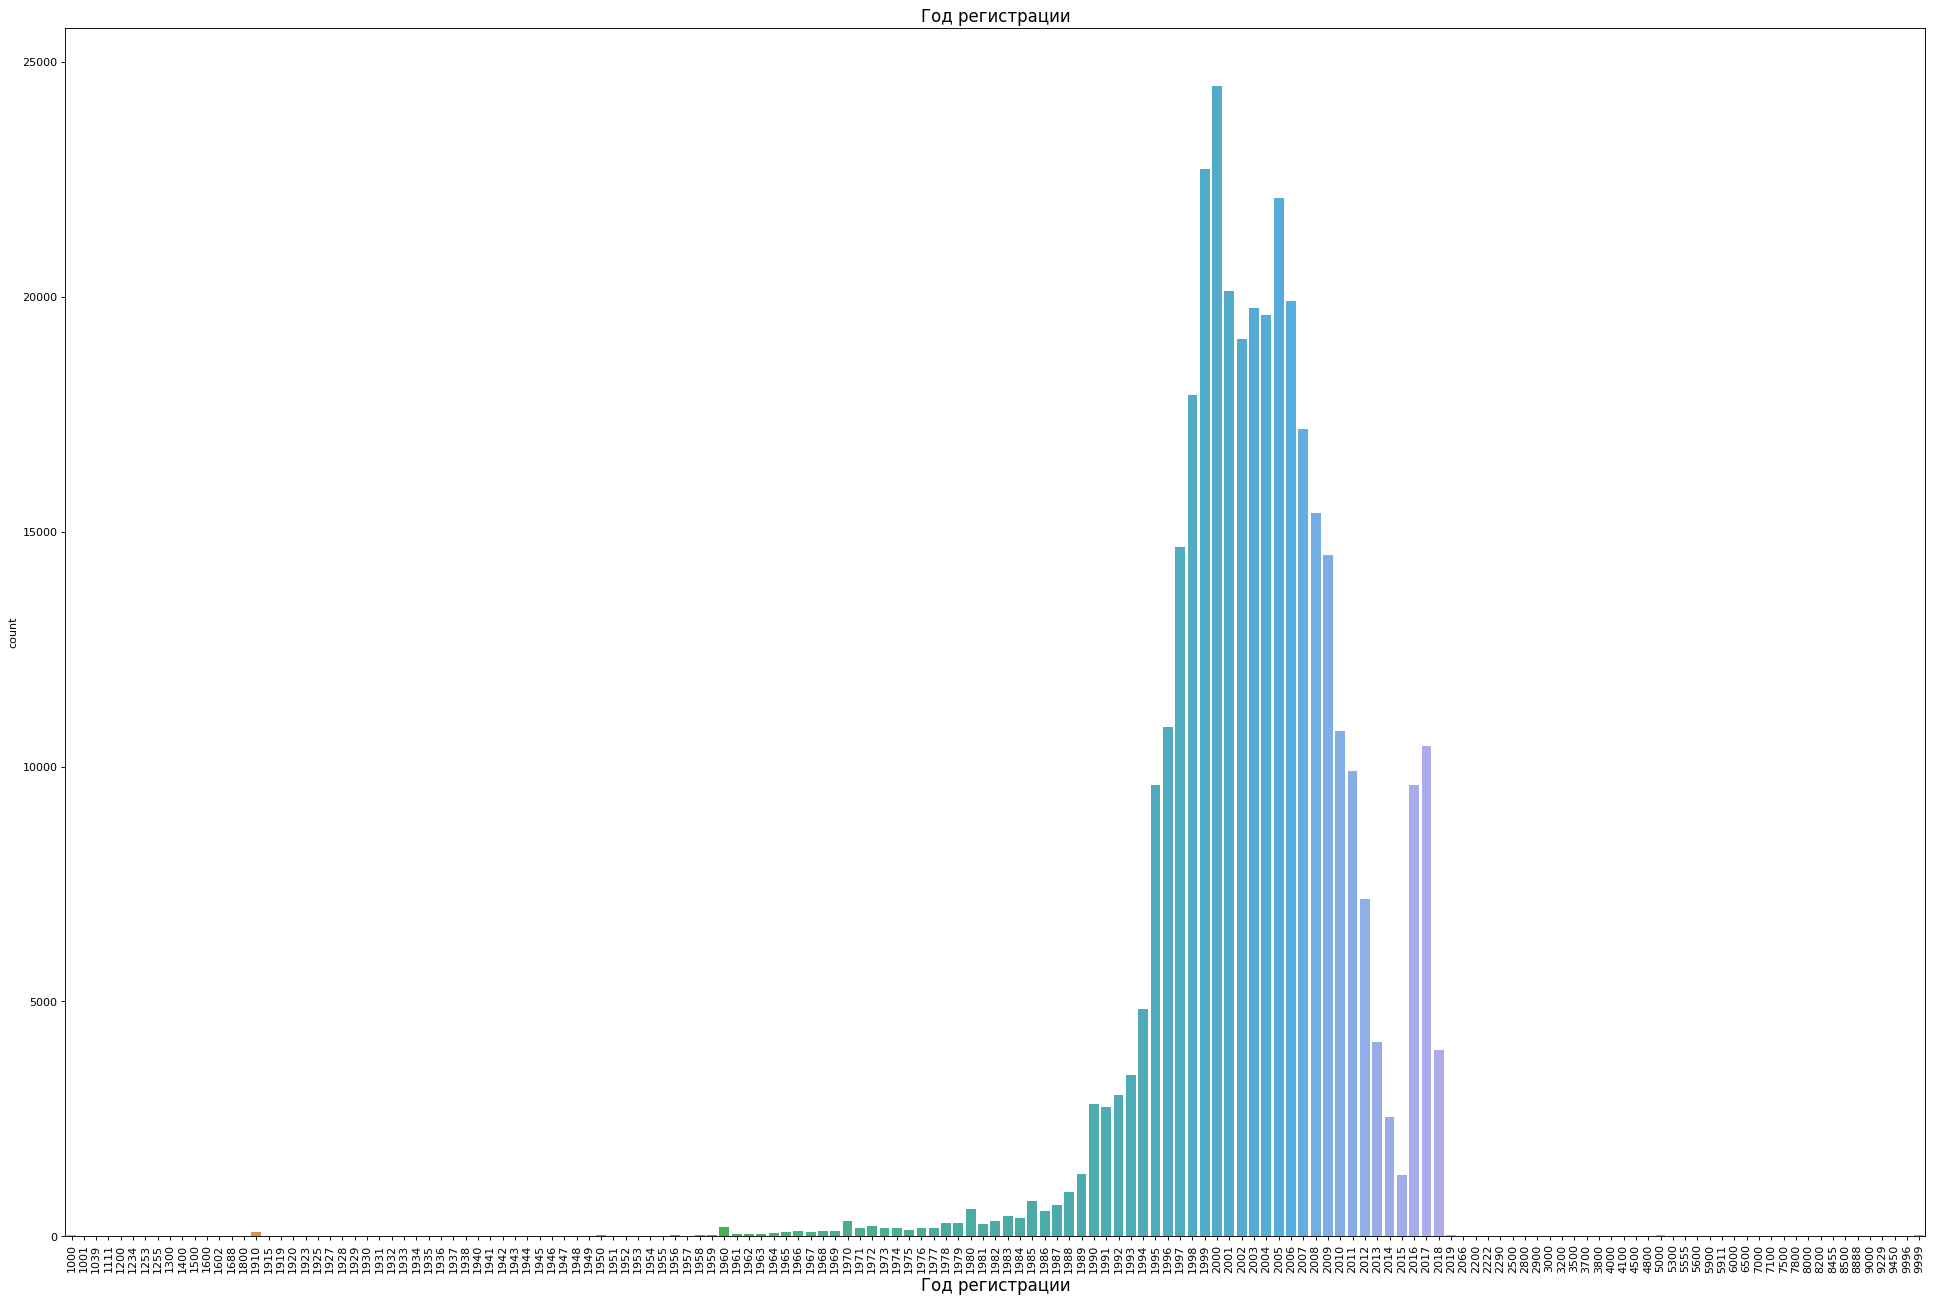

In [24]:
#Отдельно получаем график по годам регистрации
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,20), dpi=80, facecolor='w', edgecolor='r')
sns.countplot(data['registration_year'])
plt.title('Год регистрации',fontsize=15)
plt.xticks(rotation=90,)
plt.xlabel('Год регистрации',fontsize=15)
plt.show()

In [25]:
#Проверяем макс. значение скаченных анкет
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


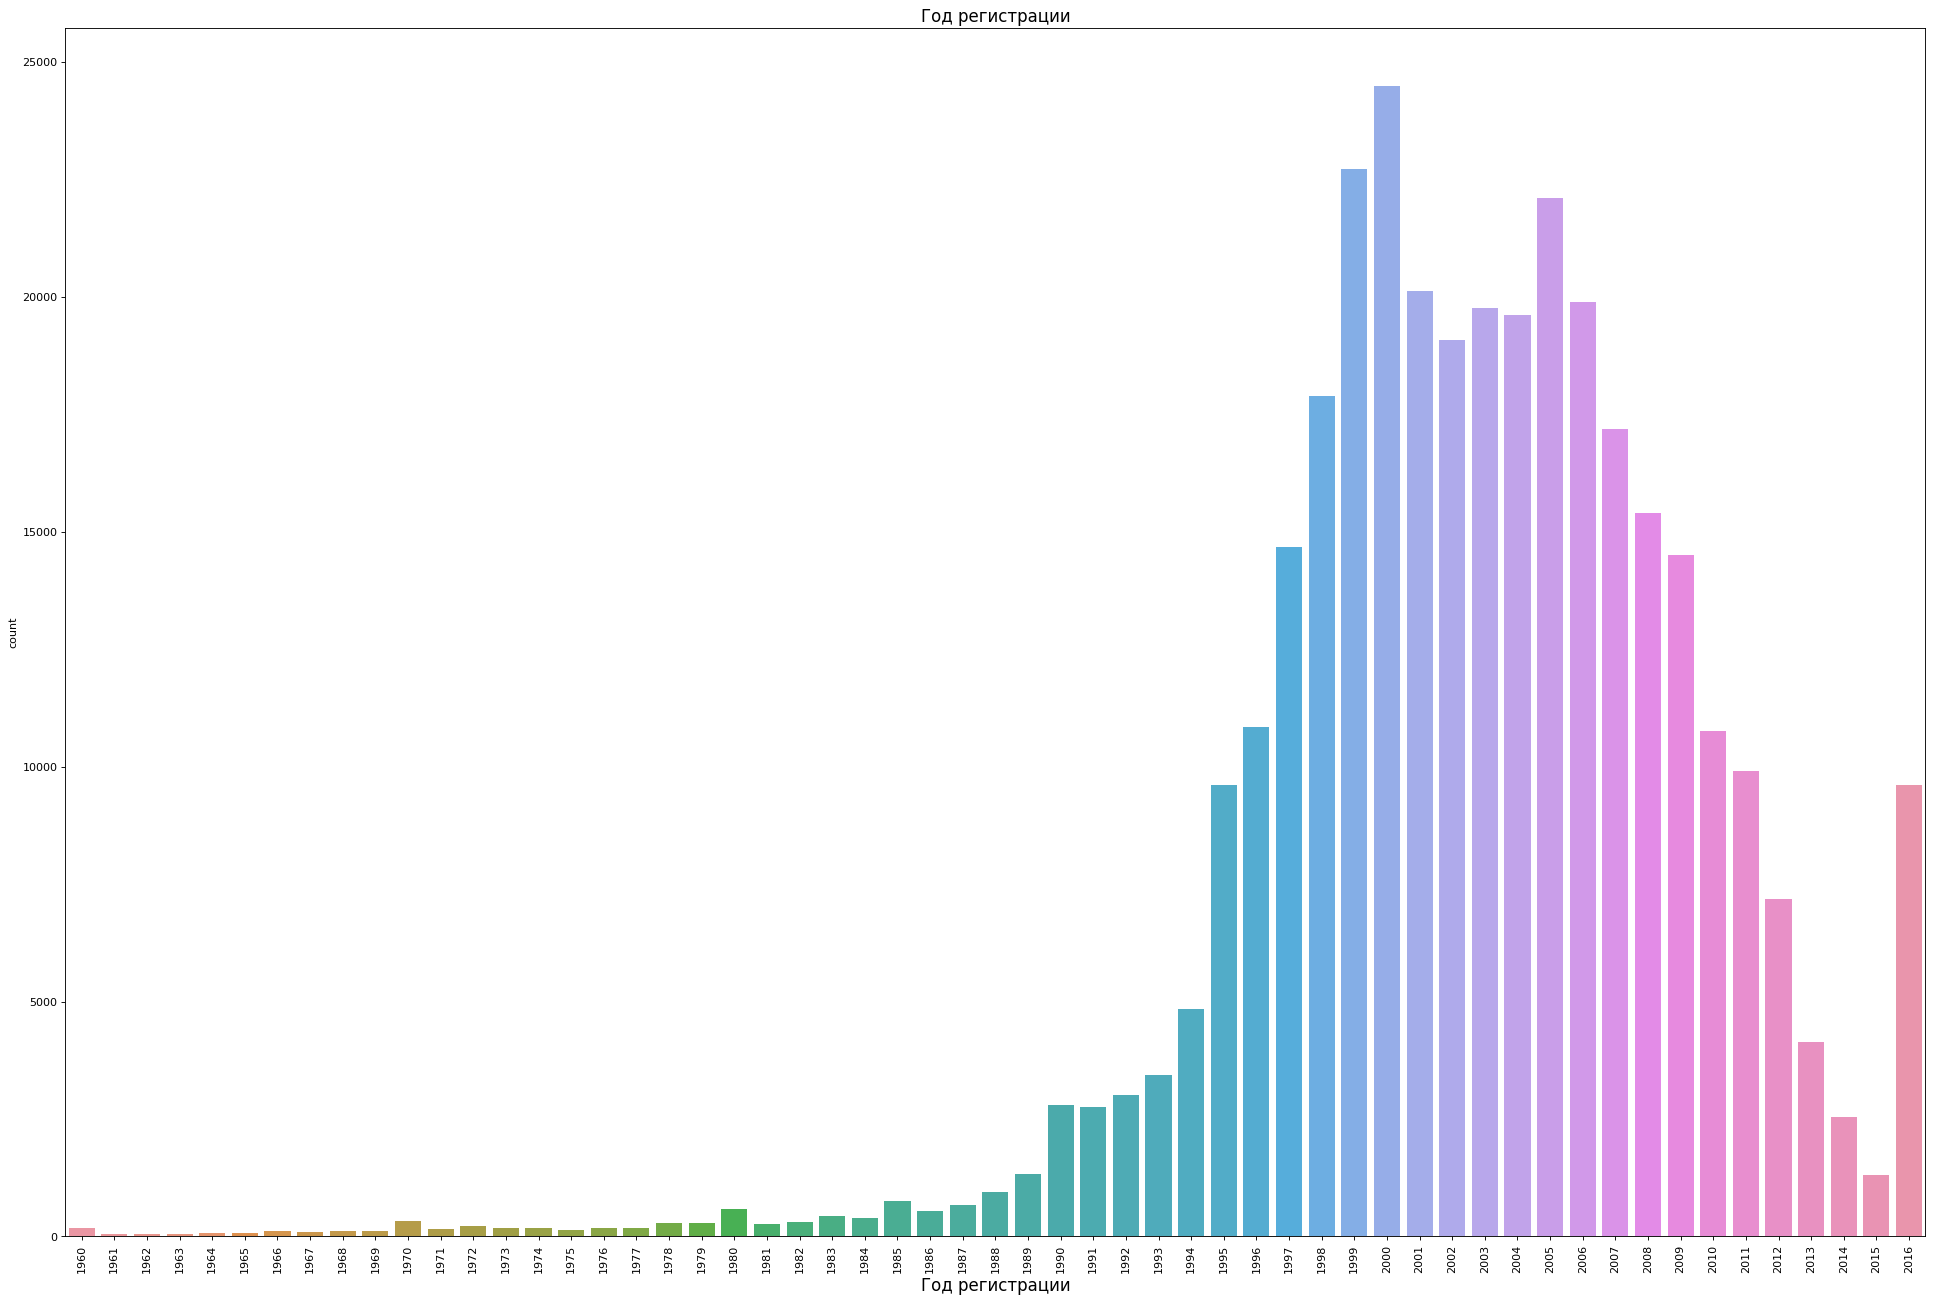

In [26]:
#Выбираем годы регистрации от 1960 до 2016 
data = data.query('registration_year > 1959 & registration_year < 2017')
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,20), dpi=80, facecolor='w', edgecolor='r')
sns.countplot(data['registration_year'])
plt.title('Год регистрации',fontsize=15)
plt.xticks(rotation=90)
plt.xlabel('Год регистрации',fontsize=15)
plt.show()

count    339413.000000
mean       4469.917885
std        4543.710777
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


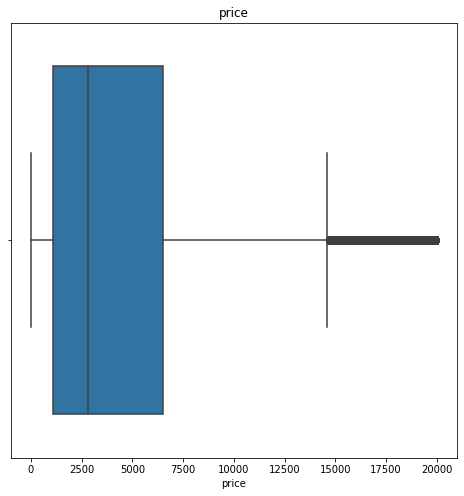

count    339413.000000
mean        111.074809
std         186.926210
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


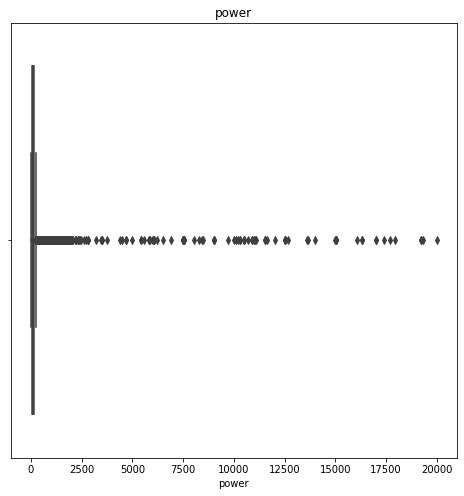

count    339413.000000
mean     128152.840345
std       37813.335030
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


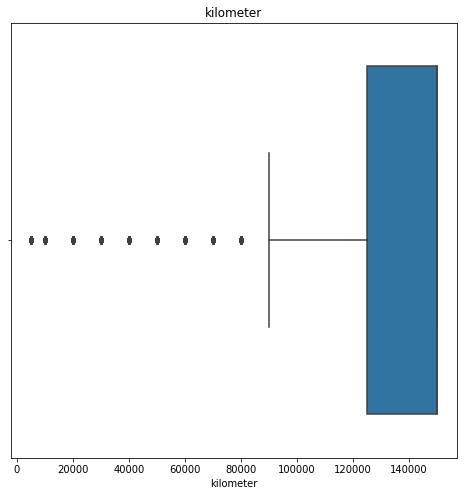

count    339413.000000
mean       2002.549684
std           6.752072
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


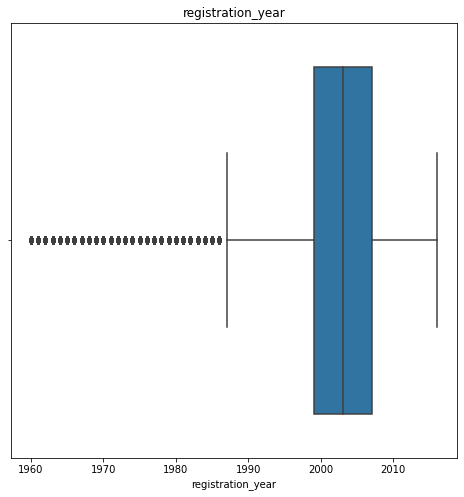

In [27]:
for i,col in enumerate(['price','power','kilometer','registration_year']):
    display(data[col].describe())
    sns.boxplot(data[col])
    plt.title(col, fontsize=12)
    plt.show();

count    339413.000000
mean       4469.917885
std        4543.710777
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


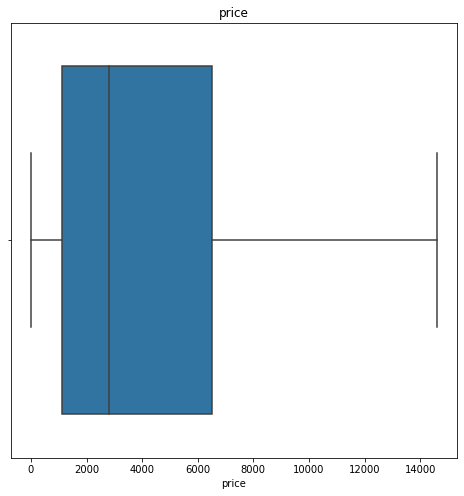

count    339413.000000
mean        111.074809
std         186.926210
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


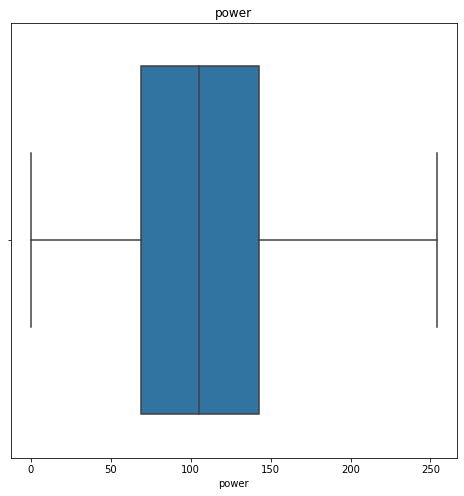

count    339413.000000
mean     128152.840345
std       37813.335030
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


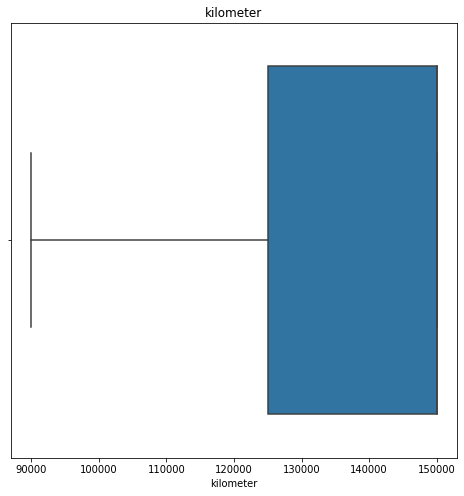

count    339413.000000
mean       2002.549684
std           6.752072
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


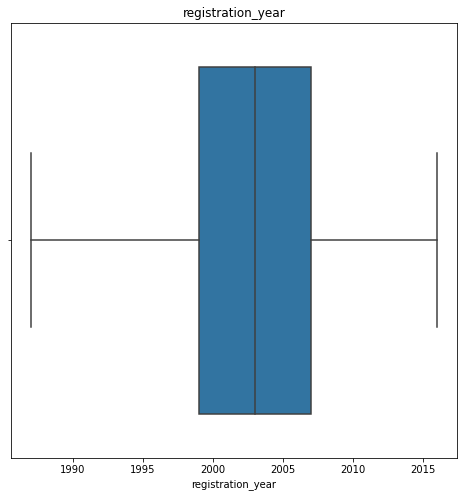

In [28]:
for i,col in enumerate(['price','power','kilometer','registration_year']):
    display(data[col].describe())
    sns.boxplot(data[col],showfliers=False)
    plt.title(col, fontsize=12)
    plt.show();

### Вывод

В трёх количественных признаках есть выбросы. Для цены выберу границу выше 100 до 15000(будем считать что есть машин каторые продаются за 100,они находятся в нерабочем состоянии). Мин. мощность в современных автомобильях состовляет 120 л.с.. Есть старые модели авто. к примеру Fiat Nuova 500 (13 л. с.),BMW Isetta (13 л. с.) но скорее всего такие автомобили сейчас встречаются редко, по этой логике оставлю автомобили с мощностю выше 50 и ниже 500 л.с..  Выбросов очень много и если я сокращю их получится,что половины данных не будет.

In [29]:
data = data.query('power > 50 & power < 500')
data = data.query('price > 100')

count    285082.000000
mean       4984.941550
std        4623.993399
min         101.000000
25%        1450.000000
50%        3350.000000
75%        7200.000000
max       20000.000000
Name: price, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


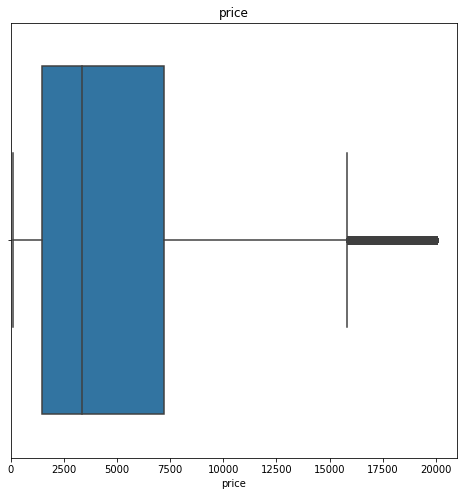

count    285082.000000
mean        123.169895
std          52.331088
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


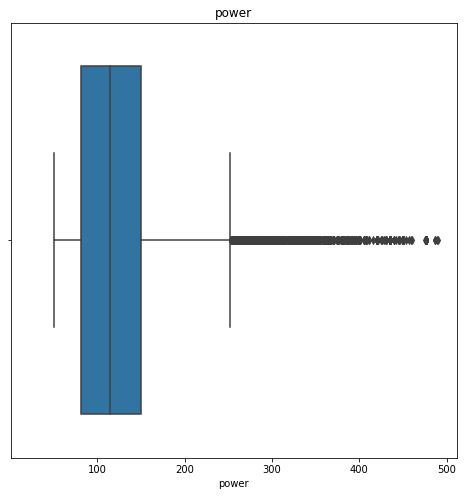

count    285082.000000
mean     128429.732498
std       36570.401126
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


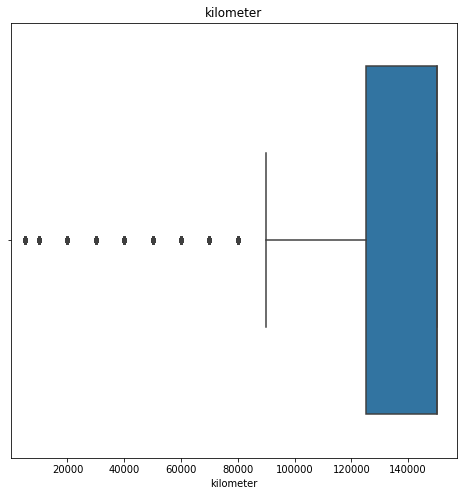

count    285082.000000
mean       2003.068110
std           6.225566
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


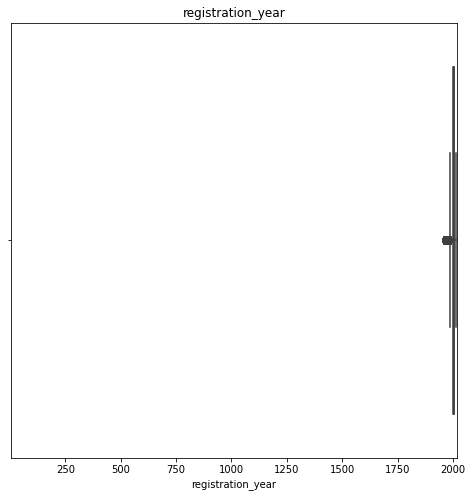

In [30]:
for i,col in enumerate(['price','power','kilometer','registration_year']):
    display(data[col].describe())
    sns.boxplot(data[col])
    plt.xlim(i)
    plt.title(col, fontsize=12)
    plt.show();

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


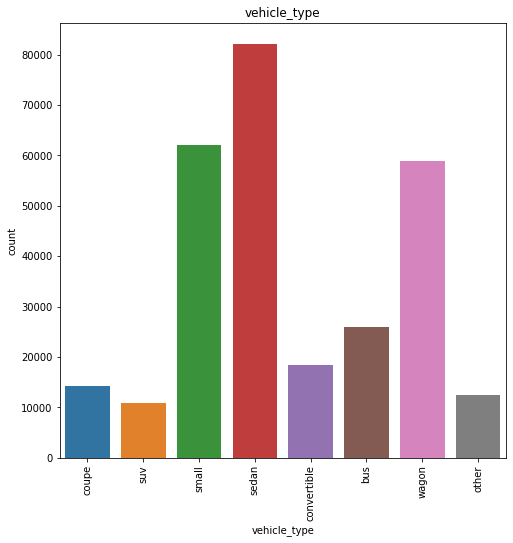

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


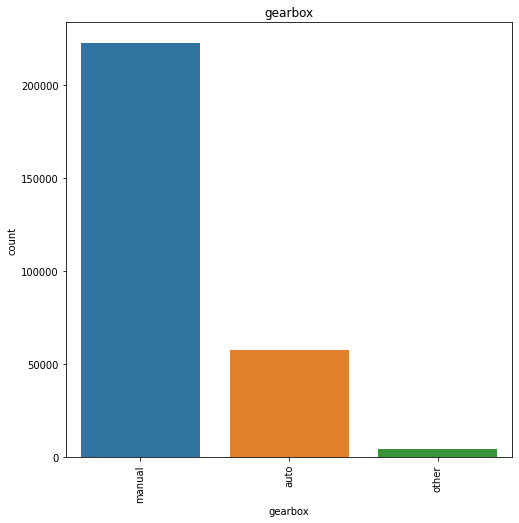

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


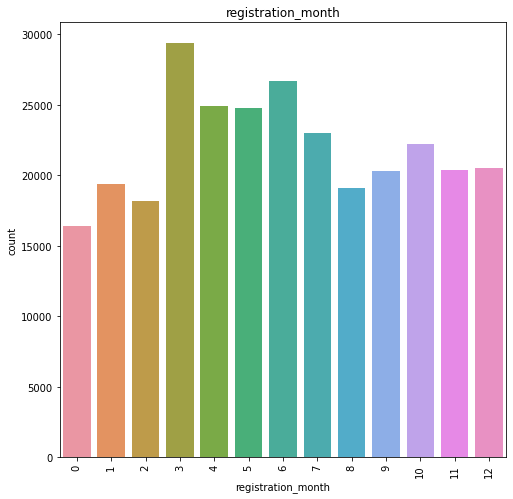

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


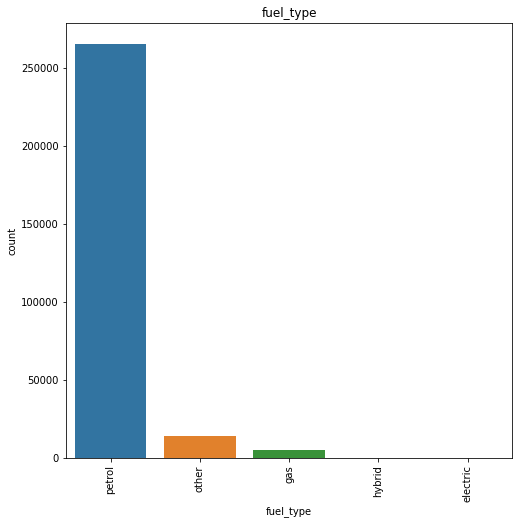

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


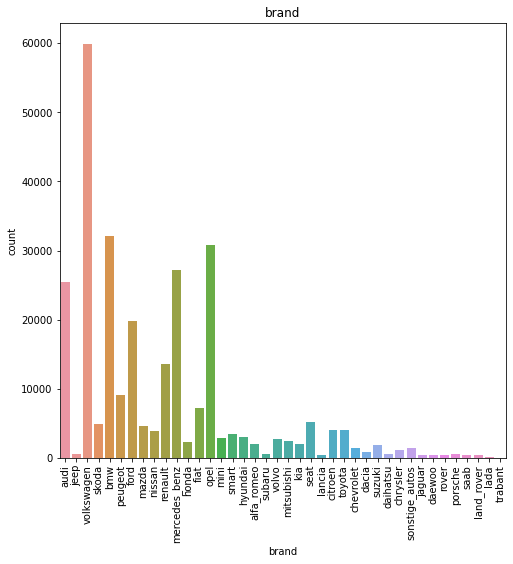

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


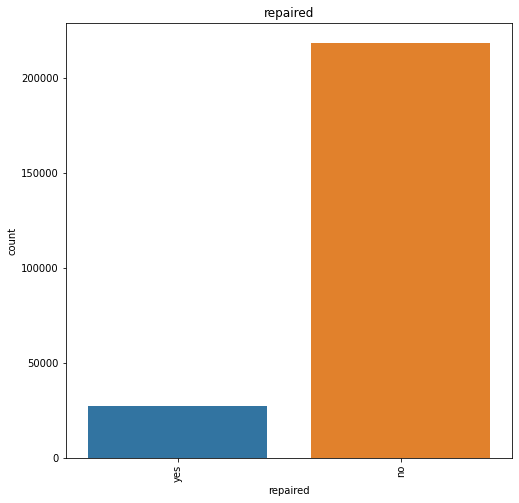

In [31]:
#Получаем график по категориальным признакам
for i,col in enumerate(['vehicle_type','gearbox','registration_month','fuel_type','brand','repaired']):
    sns.countplot(data[col])
    plt.xticks(rotation=90)
    plt.title(col, fontsize=12)
    plt.show();

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


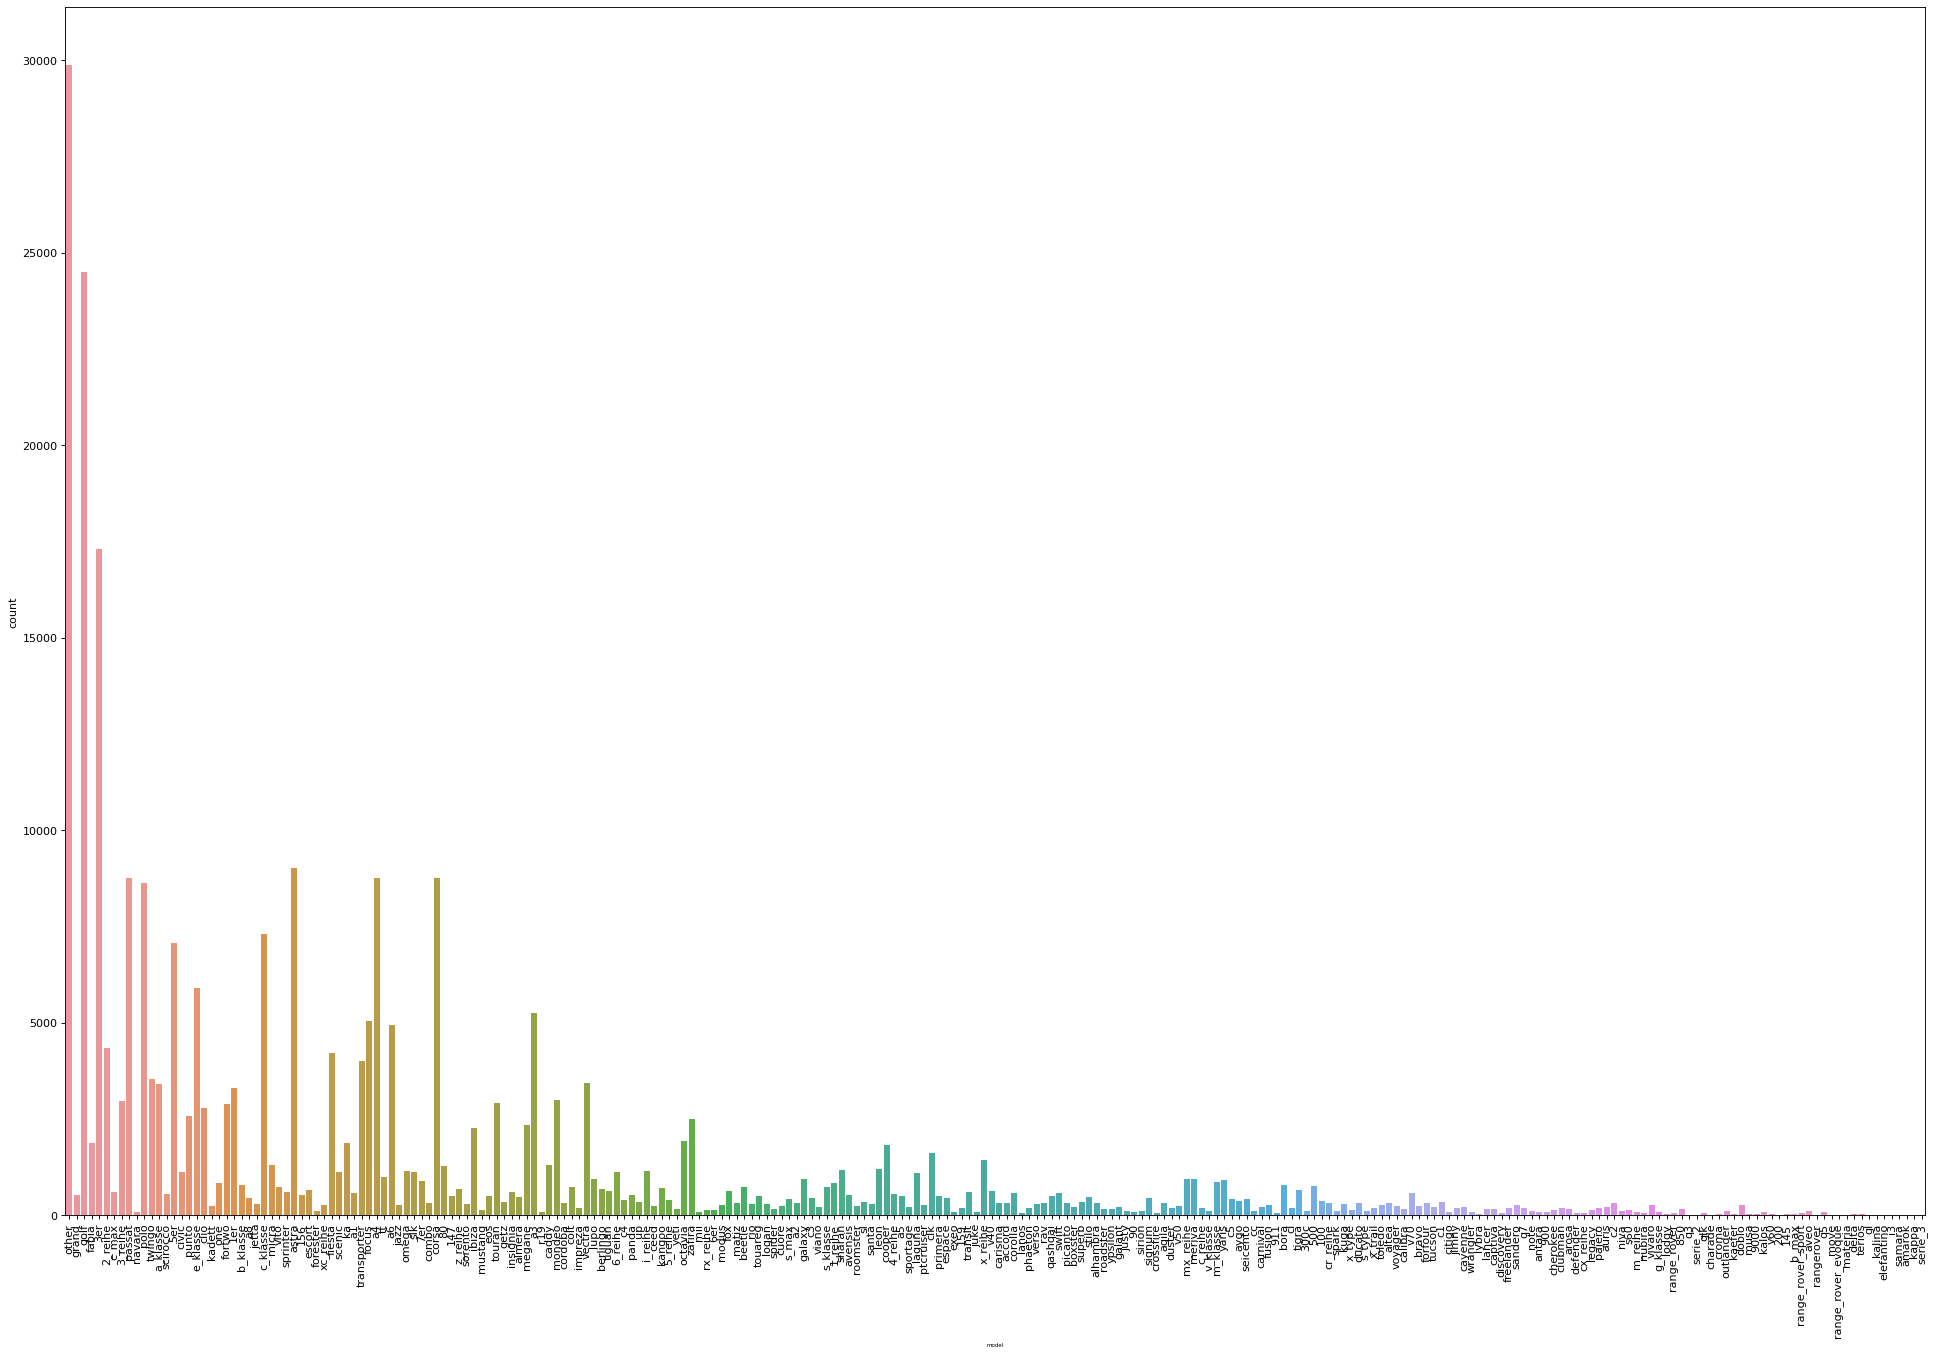

In [32]:
#Отдельно получаем график по моделям
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,20), dpi=80, facecolor='w', edgecolor='r')
sns.countplot(data['model'])
plt.xticks(rotation=90)
plt.xlabel('model',fontsize=5)
plt.show()

In [33]:
#Поскольку информативность ппризнаков 'DateCrawled,DateCreated,LastSeen,PostalCode,NumberOfPictures' не важно во время МО, удаляю их.
data.drop (data.columns[[0,6,8,10,12,13,14,15]], axis= 1 , inplace= True )
data.columns.values.tolist ()

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'kilometer',
 'fuel_type',
 'repaired']

In [34]:
#После удаления признаков проверяем явные дубликаты
display(data.duplicated().sum())
print()
display(data.index.duplicated().sum())

59211

0

In [35]:
#Удаляем явные дубликаты
data = data.drop_duplicates()

### Вывод
 
 1. Загрузила данные.
 
 2. Поменяла название столбцов. 
 
 3. Были 4 дубликата,удалила их. 
 
 4. Есть пропуски DateCrawled - 0%, VehicleType - 11%,Gearbox - 6%,Model - 6%,FuelType - 9%,Repaired - 20%. В признаке 'Repaired' и 'VehicleType' процент пропусков больше 10%. Обядинила пропуски со значением 'other'. Обработать пропуски буду в пайплайне.
 
 5. Удалила признаки 'DateCrawled,DateCreated,LastSeen,NumberOfPictures,PostalCode,LastSeen' по скольку они не несут полезной информации для МО. 
 
 6. В признаказ 'repaired' поменяла да/нет на 1/0,  'gerabox' поменяла автомат/механика на 1/0 
 
 7. Были аномалии в признаках 'price,registration_month'. Цена  равно 0-ю это аномалия. Месяц регистрации 0 это тоже аномалия. Удалила эти аномалии.
 
 8. В трёх количественных признаках есть выбросы. Для цены выберу границу выше 100(будем считать что есть машин каторые продаются за 100,они находятся в нерабочем состоянии). Мин. мощность в современных автомобильях состовляет 120 л.с.. Есть старые модели авто. к примеру Fiat Nuova 500 (13 л. с.),BMW Isetta (13 л. с.) но скорее всего такие автомобили сейчас встречаются редко, по этой логике оставлю автомобили с мощностю выше 50 и ниже 500 л.с.. Думаю целесообразно выбирать такие границы.Удалила данные машини ценоц ниже 100евро. Год регистрации оставила от 1960 до 2017(не включая).
 
9. Выбросов очень много и если я сокращю их полностью,получится,что половины данных не будет.
 
10. По категориальным данным получается больше всего обьявлении бренда WW, кузов седан, марка Golg, без ремонта, каробка автомат,тип топливо-бензин.

In [36]:
#Отдельно сахроняю количественные признаки для просмотра корреляции
num_f = data[['price','registration_year','power','kilometer','gearbox','repaired']].copy()

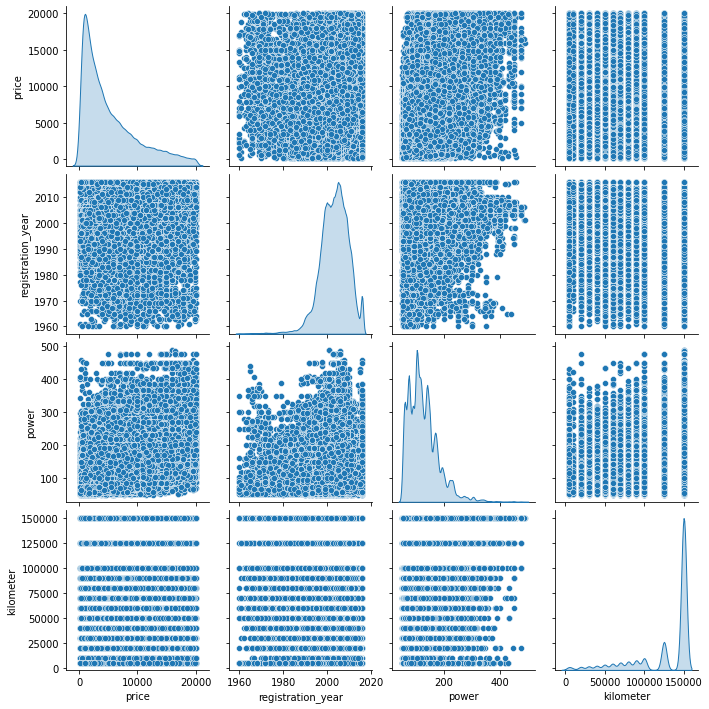

In [37]:
#Получаем кор.график по прзнакам
sns.pairplot(data=num_f, kind='scatter',diag_kind='kde');

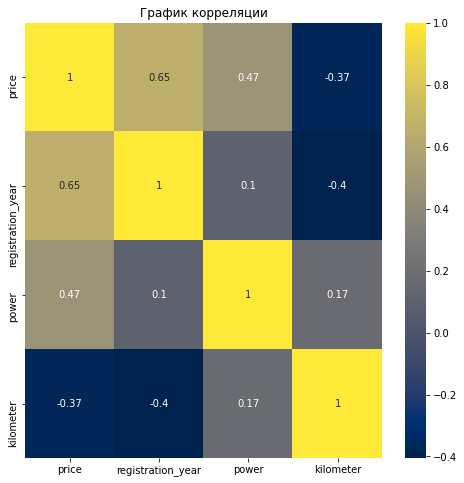

In [38]:
#Получаем кор.график по кол. прзнакам
sns.heatmap(num_f.corr(method='spearman'),  annot=True, cmap='cividis')
plt.title('График корреляции');

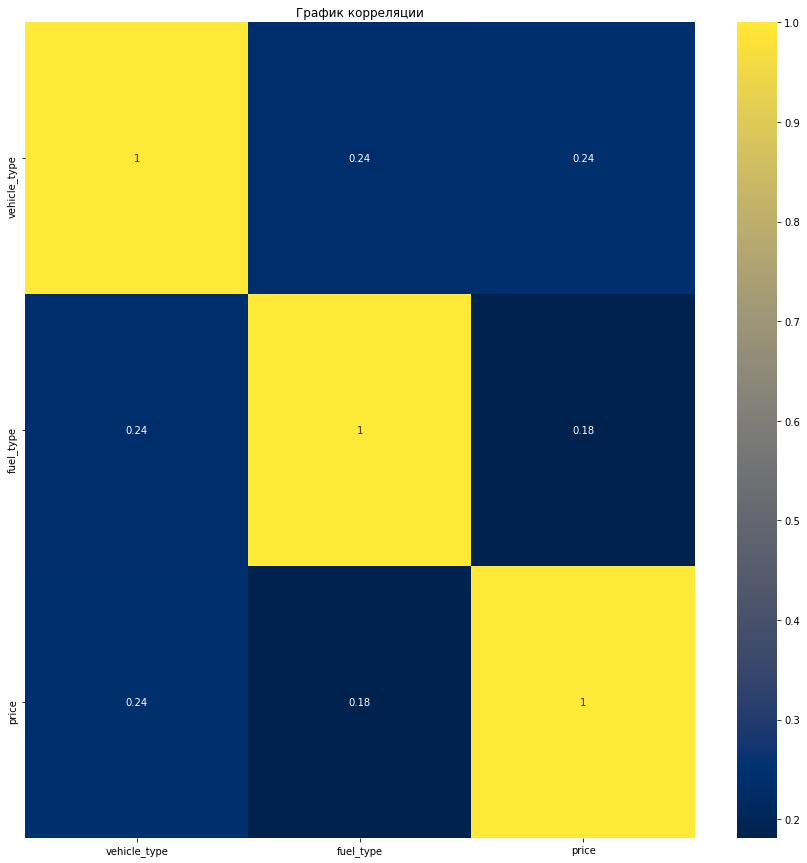

In [39]:
#Получаем кор.график по кат. прзнакам
df_phik = data[['vehicle_type','fuel_type','price']].copy()
plt.figure(figsize=(15, 15))
sns.heatmap(df_phik.phik_matrix(verbose=False,interval_cols=['price']), annot=True, cmap='cividis')
plt.title('График корреляции');

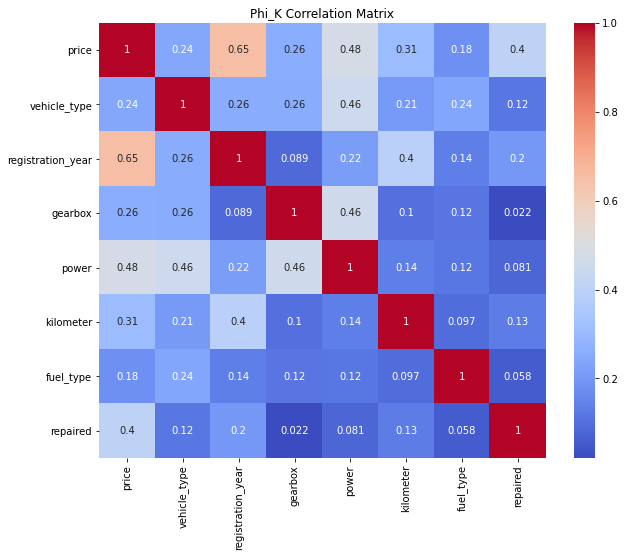

In [40]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = data.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show();

### Вывод

Шкала Чеддока

Слабая - 0.1–0.30.1–0.3 обратная (−0.1)–(−0.3)(−0.1)–(−0.3)

Умеренная - 0.3–0.50.3–0.5 обратная (−0.3)–(−0.5)(−0.3)–(−0.5)

Заметная - 0.5–0.70.5–0.7 обратная (−0.5)–(−0.7)(−0.5)–(−0.7)

Высокая - 0.7–0.90.7–0.9 обратная (−0.7)–(−0.9)(−0.7)–(−0.9)

Весьма высокая - 0.9–10.9–1 обратная (−0.9)–(−1)(−0.9)–(−1)

По графику корр. Спирмена есть заметная корреляция между признаками мощности,года регистрации и целевым признаком.

По графику корр. Фика есть заметная корр. между признаками модели,бренда и целевым признаком. Есть весьма высокая корр. между признаками модель- тип кузова и модель-бренд.

## Обучение моделей

In [41]:
%%time
#Разбиваем выборку
features =  data.drop(['price'], axis=1) 
target = data['price']
features_train, features_test, target_train, target_test = train_test_split(
    features,target,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    )

features_train.shape[0], features_test.shape[0],target_train.shape[0],target_test.shape[0]


CPU times: user 32.5 ms, sys: 412 µs, total: 32.9 ms
Wall time: 31.1 ms


(135522, 90349, 135522, 90349)

In [42]:
data.sample()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,repaired
54092,800,small,1997,manual,60,100000,petrol,yes


In [43]:
%%time
# создаём списки с названиями признаков
num_columns = [ 'registration_year','power','kilometer']
ohe_columns = ['fuel_type','vehicle_type','gearbox','repaired']
#targ_columns = ['brand','model']
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))])
# создаём пайплайн для подготовки признаков из списка targ_columns: заполнение пропусков и TARG-кодирование
# SimpleImputer + TARG
#targ_pipe = Pipeline(
#    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('targ', TargetEncoder(target_type='auto'))])
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
      #('targ', targ_pipe, targ_columns), 
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough')
data_preprocessor

CPU times: user 42 µs, sys: 4 µs, total: 46 µs
Wall time: 49.6 µs


ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['fuel_type', 'vehicle_type', 'gearbox',
                                  'repaired']),
                                ('num', MinMaxScaler(),
                                 ['registration_year', 'power', 'kilometer'])])

In [44]:
%%time
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([('preprocessor', data_preprocessor)
                       ,('models', LinearRegression())])

pipe_final

CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 21.7 µs


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['fuel_type', 'vehicle_type',
                                                   'gearbox', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models', LinearRegression())])

In [45]:
%%time
# словарь для моделей
param_grid = [
             
              {'models': [LinearRegression()]
               ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
  
             {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)]
               ,'models__max_depth': list(range(5,8))
               ,'models__max_features': list(range(5,8))
               ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
             {'models' : [LGBMRegressor()],
              'models__max_depth': list(range(2, 5, 10)),
              'models__n_estimators': list(range(10, 15, 25)),
              'models__learning_rate': list(range(1,5,110)),
              'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']},
            
            {'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
               'models__n_estimators': list(range(100,120,140)),
               'models__max_features': ['sqrt', 'log2'],
               'models__max_leaf_nodes': list(range(10,18)),
               'models__max_depth': (None, *range(2,5,10)),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
            ]

param_grid

CPU times: user 86 µs, sys: 0 ns, total: 86 µs
Wall time: 90.1 µs


[{'models': [LinearRegression()],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': [5, 6, 7],
  'models__max_features': [5, 6, 7],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LGBMRegressor()],
  'models__max_depth': [2],
  'models__n_estimators': [10],
  'models__learning_rate': [1],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [RandomForestRegressor(random_state=42)],
  'models__n_estimators': [100],
  'models__max_features': ['sqrt', 'log2'],
  'models__max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17],
  'models__max_depth': (None, 2),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [46]:
%%time
#Обучаем тренировочные выборки
pipe_final.fit(features_train, target_train)

CPU times: user 278 ms, sys: 12 ms, total: 290 ms
Wall time: 272 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['fuel_type', 'vehicle_type',
                                                   'gearbox', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models', LinearRegression())])

In [47]:
%%time
#Испльзуем RandomizedSearchCV для поиска лучших параметров
randomized_search = RandomizedSearchCV(pipe_final, param_distributions=param_grid, cv=5,
                                       scoring='neg_root_mean_squared_error',random_state=RANDOM_STATE
                                       ,n_jobs=-1, error_score='raise')
randomized_search

CPU times: user 24 µs, sys: 2 µs, total: 26 µs
Wall time: 29.8 µs


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['fuel_type',
                                                                                'vehicle_type',
                                                                                'gearbox',
                                                                                'repaired']),
                                                                              ('num',
                                                                               MinMaxS...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': (None, 2),
                                         'models__max_features': ['sqrt',
                                                                  'log2'],
                                         'models__max_leaf_nodes': [10, 11, 12,
                                                                    13, 14, 15,
                                                                    16, 17],
                                         'models__n_estimators': [100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [48]:
%%time
#Обучаем моднель по полученным данным


randomized_search.fit(features_train, target_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print (f'Метрика лучшей модели на тренировочной выборке:, {round(-(randomized_search.best_score_),1)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['fuel_type', 'vehicle_type',
                                                   'gearbox', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['registration_year', 'power',
                                    

###  Вывод 

Лучшей моделю оказаля 

LGBMRegressor(learning_rate=1, max_depth=2, n_estimators=10))])
Метрика лучшей модели на тренировочной выборке:, 2476.6

Время работы в сетке(RandomizedSearchCV) 1мин.18с.

### Предсказания

In [49]:
%%time
# В best_model будет храниться наш пайплайн
best_model = randomized_search.best_estimator_
lgb_model = best_model.named_steps['models']
lgb_model

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 25.3 µs


LGBMRegressor(learning_rate=1, max_depth=2, n_estimators=10)

In [50]:
%%time
#Кодируем признаки с помощю пайплайна
features_test = best_model.named_steps['preprocessor'].transform(features_test)

CPU times: user 93.6 ms, sys: 0 ns, total: 93.6 ms
Wall time: 131 ms


In [51]:
%%time
#Предсказываем на тестовх данных
prediction = lgb_model.predict(features_test)

CPU times: user 59.5 ms, sys: 0 ns, total: 59.5 ms
Wall time: 8.39 ms


In [52]:
%%time
#Получаем оценку метрик
rmse = mean_squared_error(target_test, prediction) ** 0.5
round(rmse,1)

CPU times: user 1.36 ms, sys: 45 µs, total: 1.4 ms
Wall time: 1.17 ms


2478.2

На тестовых данных так же получили ниже 2500.Время работы 3.25мс.


## Анализ моделей

Получила лучшую модель на трен. данных.

1. LGBMRegressor(learning_rate=1, max_depth=2, n_estimators=10)

3. Метрика лучшей модели на тренировочной выборке:, 2478.6

2. Время работы 1мин.37с.

Сделала предсказанич на тест. данных

1. Время пред. 3.25 ms

2. Метрика 2478.2

Лучшую модел сохранила в переменной <a id='the_destination'>lgb_model</a>


## Вывод

1. Загрузила данные.

2. Поменяла название столбцов.

3. Были 4 дубликата,удалила их.

4. Есть пропуски DateCrawled - 0%, VehicleType - 11%,Gearbox - 6%,Model - 6%,FuelType - 9%,Repaired - 20%. В признаке 'Repaired' и 'VehicleType' процент пропусков больше 10%. Обядинила пропуски со значением 'other'. Обработать пропуски буду в пайплайне.

5. Удалила признаки 'DateCrawled,DateCreated,LastSeen,NumberOfPictures,PostalCode,LastSeen,model,brand' по скольку они не несут полезной информации для МО.


6. Были аномалии в признаках 'price,registration_month'. Цена равно 0-ю это аномалия. Месяц регистрации 0 это тоже аномалия. Удалила эти аномалии.

7. В трёх количественных признаках есть выбросы. Для цены выберу границу выше 100(будем считать что есть машин каторые продаются за 100,они находятся в нерабочем состоянии). Мин. мощность в современных автомобильях состовляет 120 л.с.. Есть старые модели авто. к примеру Fiat Nuova 500 (13 л. с.),BMW Isetta (13 л. с.) но скорее всего такие автомобили сейчас встречаются редко, по этой логике оставлю автомобили с мощностю выше 50 и ниже 500 л.с.. Думаю целесообразно выбирать такие границы. Год регистрации оставила 1960-2017(не включительно).
8. Выбросов очень много и если я сокращю их полностью,получится,что половины данных не будет.

9. По категориальным данным получается больше всего обьявлении бренда WW, кузов седан, марка Golg, без ремонта, каробка автомат,тип топливо-бензин.
    
10. Получила лучшую модель на трен. данных.

    LGBMRegressor(learning_rate=1, max_depth=2, n_estimators=10)

    Метрика лучшей модели на тренировочной выборке:, 2478.2

    Время работы 1мин.18с.

11. Сделала предсказанич на тест. данных
  
    Время пред. 3.25 ms

    Метрика 2478.6

12. Лучшую модел сохранила в переменной lgb_model
    
    
Вывод такой - да сетка хорошый инсрумент для перебора всех моделей,но отдельное обуение моделей тоже хорошо помогает перебирать все параметры, что бы улучшить метрику и сократить время работы. Но так же это зависит от того,какая цель у МО, какие данные,сколько признаков есть в датасете, есть ли корреляция между признаками и т.д..    